In [16]:
# This notebook uses a nomogram available on the web to create an additional feature for patients
# The nomogram is available at https://nomograms.mskcc.org/Breast/BreastSLNodeMetastasisPage.aspx
# The filling and submitting of the webform is automated using the 'pyautogui' module
from pyautogui import * 
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyperclip
import os
import re
import sys
import config
import importlib
import itertools
from sklearn.linear_model import HuberRegressor
sys.path.insert(1, '/Users/yifu/PycharmProjects/Radiotherapy-Prediction')
import objects.VarReader as VarReader

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.expand_frame_repr', False)

nomogram_url = "https://nomograms.mskcc.org/Breast/BreastSLNodeMetastasisPage.aspx"
raw_data_path = "/Users/yifu/PycharmProjects/Radiotherapy-Prediction/data/output/2022-08-11-105731/DataFrames/Dataset-expert-imputed.csv"
nomogram_output_dir = "/Users/yifu/PycharmProjects/Radiotherapy-Prediction/notebooks/data/nomogram_data/nomogram_results_2022-07-31"
nomogram_output_path = os.path.join(nomogram_output_dir, "data_with_nomogram_results.csv")
nomogram_log_dir = os.path.join(nomogram_output_dir, "log")
config.metadata_path = "/Users/yifu/PycharmProjects/Radiotherapy-Prediction/data/input/metadata/Metadata.xlsx"
VarReader = VarReader.VarReader()

In [17]:
target_col = "POS_metastasis"

# Load raw data
df = pd.read_csv(raw_data_path)


# Replace the "3" values (unknown) in the truth column with np.nan using .loc
df.loc[df["POS_metastasis"] == 3, "POS_metastasis"] = np.nan
# Replace the "2" values (absent) in the truth column with 0 using .loc
df.loc[df["POS_metastasis"] == 2, "POS_metastasis"] = 0

df.head()

,PRE_record_id,PRE_dob,PRE_age_at_dx,PRE_age_at_surg,PRE_men_status,PRE_fmhx,PRE_gensus___brca1,PRE_gensus___brca2,PRE_gensus___p53,PRE_gensus___pten,PRE_gensus___other,PRE_gensus___unknown,PRE_gensus___no_gensus,PRE_systhe___chemo,PRE_systhe___hormonal,PRE_systhe___chemo_and_hormonal,PRE_systhe___no_systhe,PRE_systhe___radiation,PRE_tumor_laterality,PRE_height_cm,PRE_bmi,PRE_weight_kg,PRE_bra_cup_size,PRE_palpability,PRE_axillary_lymph_node_palpab,PRE_dximg___mammography,PRE_dximg___ultrasound,PRE_dximg___mri,PRE_dximg_date,PRE_bi_rads_score,PRE_img_size,PRE_tumor_max_size_composite,PRE_foci,PRE_tumor_stge,PRE_abnormal_lymph,PRE_susp_LN_prsnt_composite,PRE_lymph_node_max_size_mm,PRE_susp_LN_size_composite,PRE_tumor_size_mm,PRE_microcalcifications,PRE_extent_of_calcification_ma,PRE_prominent_axillary_lymph,PRE_lymph_node_max_size_mm0,PRE_backgroun_enhancement,PRE_max_enhancement_measurment,PRE_axillary_lymphadenopathy,PRE_internal_mammary_lymphaden,PRE_high_grade_fdg_foci_presen,PRE_size_of_the_largest_foci_c,PRE_axillary_lymphadenopathy_p,PRE_axillary_lymph_node_max_si,PRE_int_mammary_lymphade_pet,PRE_internal_mammary_lymph_nod,PRE_pre_op_biop_date,PRE_pre_op_biopsy,PRE_tumor_location,PRE_tumor_location_trans,PRE_his_subtype___idc,PRE_his_subtype___ilc,PRE_his_subtype___dcis,PRE_his_subtype___lcis,PRE_his_subtype___inv_mucinous,PRE_his_subtype___papillary,PRE_specify_histology_if_non_o,PRE_tumor_grade,PRE_margin_status,PRE_closest_margin,PRE_num_closest_margins_trans,PRE_distance_from_closest_marg,PRE_lymphovascular_invasion0,PRE_er_status,PRE_pr_status,PRE_her_status,PRE_imaging_and_biopsy_concord,PRE_axillary_lymph_node_core_b,PRE_metastatic_carcinoma_on_ax,PRE_surg_indicat_prim___primary_tx,PRE_surg_indicat_prim___reexcis_marg+_bcs,PRE_surg_indicat_prim___compl_mast_marg+_bcs,PRE_surg_indicat_prim___recurrent_cancer,PRE_surg_indicat_prim___second_primary,PRE_laterality,PRE_surgery_date,PRE_breast_procedure,PRE_ax_surg___no_ax_surg,PRE_ax_surg___sln_biopsy,PRE_ax_surg___ax_ln_dissect,INT_lymph_nodes,INT_sln,POS_number_of_positive_sln,POS_ax_nodes,POS_mastectomy_weight_g,POS_tumor_size,POS_tumor_loc,POS_tumor_location_trans,POS_his_type___idc,POS_his_type___ilc,POS_his_type___dcis,POS_his_type___lcis,POS_his_type___other,POS_his_type___no_residual,POS_his_type___inv_mucinous,POS_his_type___inv_papillary,POS_specify_histology_if_other,POS_insitu_upstaged,POS_tu_grade,POS_tumor_focality,POS_num_foci,POS_lymphovascular_invasion,POS_in_situ_component_present,POS_in_situ_component_type___dcis,POS_in_situ_component_type___lcis,POS_in_situ_component_size_mm,POS_in_situ_component_grade,POS_mar_status,POS_clos_margin___posterior,POS_clos_margin___anterior,POS_clos_margin___medial,POS_clos_margin___lateral,POS_clos_margin___inferior,POS_clos_margin___superior,POS_clos_margin___other,POS_dis_closest_margin,POS_metastasis,POS_ln_w_micrometastasis,POS_ln_w_macrometastasis,POS_size_of_largest_nodal_meta,POS_extranodal_extension,POS_extent_of_extranodal_exten,POS_did_the_patient_receive_pm,POS_did_the_patient_reject_pmr,POS_data_collection_fields_complete
0,292.0,1966,51.0,51.0,0.0,0.0,0,0,0,0,0,1,0,0,0,0,1,0,2.0,NaN,NaN,NaN,NaN,0.0,0,1,1,0,2017.0,4.3,31.0,31.0,1,NaN,0,0,NaN,0.0,NaN,1.0,9.0,2,NaN,2,0.0,0,0,NaN,NaN,0,NaN,0,0,2017.0,1.0,NaN,NaN,0,0,1,0,0,0,NaN,2.0,NaN,NaN,NaN,NaN,0,1.0,1.5,1.5,NaN,0,0.0,1,0,0,0,0,2.0,2017.0,2.0,0,1,0,1.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,0,0,1,0,0,0,0,0,NaN,0.0,NaN,NaN,NaN,2.0,1.0,1,0,25.0,2.0,1.0,0,0,0,0,0,0,1,0.25,0.0,NaN,NaN,NaN,2.0,NaN,1.0,0.0,2
1,491.0,1948,66.0,66.0,2.0,0.0,0,0,0,0,0,1,0,0,0,0,1,0,1.0,157.0,25.964542,64.0,NaN,1.0,0,1,1,0,2014.0,NaN,7.0,15.0,1,NaN,0,0,NaN,0.0,15.0,1.0,0.0,2,NaN,2,0.0,0,0,NaN,NaN,0,NaN,0,0,2014.0,2.0,NaN,NaN,0,1,0,0,0,0,NaN,2.0,1.0,NaN,2.0,NaN,0,1.0,1.0,2.0,1.0,0,0.0,0,0,1,0,0,1.0,2014.0,3.0,0,0,1,10.0,0.0,0.0,10.0,NaN,NaN,NaN,NaN,0,0,0,0,0,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,2.0,0,0,0,0,0,0,0,NaN,1.0,NaN,NaN,NaN,1.0,NaN,1.0,0.0,2
2,296.0,1959,58.0,59.0,2.0,1.0,0,1,0

In [ ]:
"""
Create a subset of columns required by nomogram

Nomogram website: https://nomograms.mskcc.org/Breast/BreastSLNodeMetastasisPage.aspx

The columns are:
Current Age (20 to 91 yrs)
    Enter current age. Must be between 20 and 91. 
Breast Tumor Size  (0.1 to 11.0 cm)
    Size of the primary tumor (as measured either in imaging study or pathological exam), in centimeters.
Special Type? (boolean)
    Check box if tumor has been pathologically defined as pure tubular, pure colloid (mucinous), or typical medullary carcinomas
    on the pathology report. Other histologies such as atypical medullary carcinoma or carcinoma with ductal and lobular features should 
    be classified as ductal -- see Tumor Type and Grade section below for more details.
Tumor is confined to UIQ? (boolean)
    Check box if tumor is confined within the upper inner quadrant (UIQ) of the breast.
Lymphatic or Vascular Structure Involvement (boolean)
    Check box if one or more tumor cells found in the blood or lymphatic vessels.
Multifocality? (boolean)
    Check box if breast cancer has cancer cells seperated from the main tumor mass.
Tumor Type and Grade (Ductal I, Ductal II, Ductal III, Lobular)
    Indicate if tumor type is ductal or lobular, as noted in the pathology report.
    If ductal, indicate the nuclear grade -- 
        I: slight or no variation in the size and shape of the nucleus;
        II: moderate variation in the size and shape of the nucleus;
        III: marked variation in the size and shape of the nucleus.
Estrogen-Receptor Status (Negative, Positive, Unknown)
    Select NEGATIVE if estrogen receptors stain positive in <10% of cells;
    Select POSITIVE if estrogen receptors stain positive in ≥10% of cells.
Progesterone-Receptor Status
    Select NEGATIVE if progesterone receptors stain positive in <10% of cells;
    select POSITIVE if progesterone receptors stain positive in ≥10% of cells.
"""

from typing import Optional, List

class FieldType:
    """
    Enum for field type
    """
    CHECKBOX = "CHECKBOX"
    DROPDOWN = "DROPDOWN"
    TEXTAREA = "TEXTAREA"
    RESULT = "RESULT"
    CALCULATE = "CALCULATE"
    CLEAR = "CLEAR"
    

class NomogramField:
    
    def __init__(self, web_field_name: str, web_field_type: FieldType, df_column_name: str, dropdown_options: List[str] = []) -> None:
        """Object for holding and structuring the information to fill the webform automatically

        Args:
            web_field_name (str): The name as it appears on the nomogram website
            web_field_type (FieldType): The type of the webform field
            df_column_name (str): The name of column in the local dataset
        """
        self.web_field_name = web_field_name
        self.web_field_type = web_field_type
        self.df_column_name = df_column_name
        self.webform_x_coord = None
        self.webform_y_coord = None
        self.dropdown_coords = None
        self.dropdown_options = dropdown_options
    
    def update_webform_coordinates(self) -> None:
        """
        Update the coordinates of the webform field using the current mouse location
        """
        field_type = self.web_field_type
        alert(
            f"Calibrating the screen coordinates of '{self.web_field_name}' on webform...\n"
            "\n\nINSTRUCTIONS:\n\n"
            "Place your mouse where the field can be filled, and press Enter without moving the mouse.\n" \
            "The very tip of the mouse pointer should be INSIDE the checkbox, text area, or drop down menu."
            "The location/scrolling of the webform should not be changed during the entire calibration process for all fields.",
            title=f"Calibrating Screen Coordinates",
            button="Press Enter while holding the mouse in place to continue"
            )
        self.webform_x_coord, self.webform_y_coord = position()
        alert(
            f"Coordinates of '{self.web_field_name}' updated: {self.webform_x_coord}, {self.webform_y_coord}",
            title="Coordinates Updated", 
            button="Press Enter to continue"
        )
        if field_type == FieldType.DROPDOWN:
            dropdown_coords = {}
            for option in self.dropdown_options:
                alert(
                    f"'{self.web_field_name}' is a dropdown menu, calibration is needed for each option available.\n"
                    "Please make sure the dropdown menu isn't chosen (completely blank)\n"
                    "Then, click the blank dropdown menu to open it.\n"
                    f"Then, hover the tip of the mouse pointer on the dropdown option for '{option}'\n"
                    "Then, mark the location of the tip of the mouse pointer on your screen using your finger or pen."
                    "Then, come back to this message box, click this box to make window active, and"
                    "hover your mouse back to the marked location. Lastly, press Enter to continue.\n",
                    button="Press Enter to continue",
                    title=f"Calibrating for {option}"
                )
                option_x_coord, option_y_coord = position()
                alert(
                    f"Coordinates of '{self.web_field_name}' = '{option}' updated: {option_x_coord}, {option_y_coord}",
                    title="Coordinates Updated", 
                    button="Press Enter to continue"
                )
                dropdown_coords[option] = (option_x_coord, option_y_coord)
            self.dropdown_coords = dropdown_coords
        elif field_type == FieldType.RESULT:
            result_coords = {}
            alert(
                "Move the cursor to the TOP-LEFT corner of the grey box where the nomogram will output the probabilities "
                "This script will drag across the area to select the resulting probability to be copied.",
                title="Calibrating for Dragging and Copying Result",
                button="Press Enter to continue"
            )
            result_coords["top_left"] = position()
            alert(
                "Move the cursor to the BOTTOM-RIGHT corner of the grey box where the nomogram will output the probabilities "
                "This script will drag across the area to select the resulting probability to be copied.",
                title="Calibrating for Dragging and Copying Result",
                button="Press Enter to continue"
            )
            result_coords["bottom_right"] = position()
            self.result_coords = result_coords

        
    def get_dropdown_option_coords(self, value: str):
        """Given a value, return the coordinates of the dropdown option

        Args:
            value (str): The value of the dropdown option
        Raises:
            ValueError: If the value is not supported
        """
        if value not in self.dropdown_options:
            raise ValueError(f"Unsupported dropdown option {value}.")
        else:
            return self.dropdown_coords[value]


    def fill_value(self, value: str) -> Optional[float]:
        """Fill the patient value in monogram, and if the field is RESULT, return the probability

        Args:
            value (str): value to be filled

        Raises:
            Exception: If the field is not supported

        Returns:
            Optional[float]: probability from the nomogram, within range [0, 1.00]
        """
        print(f"{self.web_field_name[:10]} = {value}\t|", end="\t")
        field_type = self.web_field_type
        webform_x_coord, webform_y_coord = self.webform_x_coord, self.webform_y_coord
        if field_type == FieldType.CLEAR:
            clear_field = nomogram_fields["Clear"]
            click(clear_field.webform_x_coord, clear_field.webform_y_coord)
            time.sleep(0.5)
            click(clear_field.webform_x_coord, clear_field.webform_y_coord)
            time.sleep(1)
        elif field_type == FieldType.TEXTAREA:
            doubleClick(webform_x_coord, webform_y_coord, interval=0.2)
            time.sleep(0.1)
            typewrite(value)
            # Press tab to clear auto-completes
            time.sleep(0.1)
            press("tab")
        elif field_type == FieldType.CHECKBOX:
            if value == "Yes":
                click(webform_x_coord, webform_y_coord)
        elif field_type == FieldType.DROPDOWN:
            click(webform_x_coord, webform_y_coord)
            time.sleep(0.1)
            option_x_coord, option_y_coord = self.get_dropdown_option_coords(value)
            time.sleep(0.1)
            click(option_x_coord, option_y_coord)
        elif field_type == FieldType.CALCULATE:
            click(webform_x_coord, webform_y_coord)
            time.sleep(1)
        elif field_type == FieldType.RESULT:
            top_left_coords = self.result_coords["top_left"]
            bottom_right_coords = self.result_coords["bottom_right"]
            moveTo(top_left_coords.x, top_left_coords.y)
            time.sleep(0.1)
            dragTo(bottom_right_coords.x, bottom_right_coords.y, duration=0.1, button="left")
            if os_type == "Windows":
                hotkey("ctrl", "c")
            elif os_type == "Mac":
                hotkey("command", "c")
            time.sleep(0.1)
            result = pyperclip.paste()
            if "%" in result:
                result = result.replace("%", "")
                result = round(float(result) / 100, 4)
                pyperclip.copy(result)
            print(f"The resulting probability is {result}")
        else:
            raise ValueError(f"Unknown field type: {field_type}")

        if field_type == FieldType.RESULT:
            return result
        
        
def get_value_from_patient(field, row: pd.Series) -> str:
    """Get the appropriate nomogram field value from patient's row of data

    Args:
        row (pd.series): patient's row of data in the dataframe
    
    Returns:
        str: the value for the nomogram field
    """
    field_name = field.web_field_name
    if field_name in ["Clear", "Calculate",]:
        return None
    elif field_name == "Current Age":
        # Use either age_at_dx if available, else age_at_surg 
        if str(row["PRE_age_at_dx"]) != "nan":
            age = row["PRE_age_at_dx"]
        # elif str(row["PRE_age_at_surg"]) != "nan":
        #     age = row["PRE_age_at_surg"]
        else:
            raise ValueError("No age available")
        # Ensure age in range [20, 91]
        if age < 20:
            age = 20
        elif age > 91:
            age = 91
        return str(age)
    elif field_name == "Breast Tumor Size":
        size = row["PRE_tumor_max_size_composite"]
        if str(size) == "nan":
            raise ValueError("No tumor size available")
        size = float(size) / 10
        # Ensure size in range [0.1, 11.0 cm]
        if size < 0.1:
            size = 0.1
        elif size > 11.0:
            size = 11.0
        return str(size)
    elif field_name == "Special Type?":
        is_mucinous = float(row["PRE_his_subtype___inv_mucinous"]) == 1
        if is_mucinous:
            return "Yes"
        else:
            return "No"
    elif field_name == "Tumor is confined to UIQ?":
        tumor_location_trans = row["PRE_tumor_location_trans"]
        if str(tumor_location_trans) == "nan":
            return "No"
        # left breast is positive, right breast is negative
        tumor_location_trans = int(tumor_location_trans)
        # if -12 <= tumor_location_trans <= -9  r tumor_location_trans == 12 or 0 < tumor_location_trans <= 3:
        # right breast UIQ: 12, 1, 2, 3 o' clock; left breast UIQ: 9, 10, 11, 12 o' clock
        if (tumor_location_trans in [-12, -1, -2, -3, 9, 10, 11, 12]):
            return "Yes"
        else:
            return "No"
    elif field_name == "Lymphatic or Vascular Structure Involvement (LymphovascularInvasion)":
        lvi = row["PRE_lymphovascular_invasion0"]
        if str(lvi) == "nan":
            raise ValueError("No lymphatic invasion available")
        elif float(lvi) == 0:
            return "No"
        else:
            return "Yes"
    elif field_name == "Multifocality?":
        focality = row["PRE_foci"]
        if str(focality) == "nan":
            raise ValueError("No focality available")
        elif int(focality) > 1:
            return "Yes"
        else:
            return "No"
    elif field_name == "Tumor Type and Grade":
        # is_lobular = float(row["PRE_his_subtype___2"]) == 1 or float(row["PRE_his_subtype___4"]) == 1
        # is_ductal =  float(row["PRE_his_subtype___1"]) == 1 or float(row["PRE_his_subtype___3"]) == 1
        is_lobular = float(row["PRE_his_subtype___ilc"]) == 1 or float(row["PRE_his_subtype___lcis"]) == 1
        is_ductal =  float(row["PRE_his_subtype___idc"]) == 1 or float(row["PRE_his_subtype___dcis"]) == 1
        if is_lobular and not is_ductal:
            return "Lobular"
        grade = str(row["PRE_tumor_grade"])
        if grade == "nan":
            raise ValueError("No grade available")
        elif float(grade) == 1:
            return "Ductal, I"
        elif float(grade) == 3:
            return "Ductal, III"
        else:
            return "Ductal, II"
    elif field_name == "Estrogen-Receptor Status":
        er_status = row["PRE_er_status"]
        if str(er_status) == "nan":
            raise ValueError("No estrogen receptor status available")
        elif float(er_status) == 1:
            return "Positive"
        elif float(er_status) == 2:
            return "Negative"
        else:
            return "Unknown"
    elif field_name == "Progesterone-Receptor Status":
        pr_status = row["PRE_pr_status"]
        if str(pr_status) == "nan":
            raise ValueError("No progesterone receptor status available")
        elif float(pr_status) == 1:
            return "Positive"
        elif float(pr_status) == 2:
            return "Negative"
        else:
            return "Unknown"
    else:
        raise ValueError(f"Unsupported field name {field_name}")
    

In [ ]:
from collections import OrderedDict


nomogram_fields = OrderedDict({
    "Clear": NomogramField(
        web_field_name="Clear",
        web_field_type=FieldType.CLEAR,
        df_column_name=None
    ),
    "Current Age": NomogramField(
        web_field_name="Current Age",
        web_field_type=FieldType.TEXTAREA,
        df_column_name="nomogram_age"
    ),
    "Breast Tumor Size": NomogramField(
        web_field_name="Breast Tumor Size",
        web_field_type=FieldType.TEXTAREA,
        df_column_name="nomogram_max_tumor_size_composite"
    ),
    "Special Type?": NomogramField(
        web_field_name="Special Type?",
        web_field_type=FieldType.CHECKBOX,
        df_column_name="nomogram_is_special_type"
    ),
    "Tumor is confined...": NomogramField(
        web_field_name="Tumor is confined to UIQ?",
        web_field_type=FieldType.CHECKBOX,
        df_column_name="nomogram_tumor_confined_uiq"
    ),
    "Lymphatic or Vascular...": NomogramField(
        web_field_name="Lymphatic or Vascular Structure Involvement (LymphovascularInvasion)",
        web_field_type=FieldType.CHECKBOX,
        df_column_name="nomogram_is_lymphovascular_invasive"  # TODO whether to use POST LVI?
    ),
    "Multifocality?": NomogramField(
        web_field_name="Multifocality?",
        web_field_type=FieldType.CHECKBOX,
        df_column_name="nomogram_is_multifocal"
    ),
    "Tumor Type and Grade": NomogramField(
        web_field_name="Tumor Type and Grade",
        web_field_type=FieldType.DROPDOWN,
        df_column_name="nomogram_tumor_type_and_grade",
        dropdown_options=["Ductal, I", "Ductal, II", "Ductal, III", "Lobular"]
    ),
    "Estrogen-Receptor Status": NomogramField(
        web_field_name="Estrogen-Receptor Status",
        web_field_type=FieldType.DROPDOWN,
        df_column_name="nomogram_er_status",
        dropdown_options=["Negative", "Positive", "Unknown"]
    ),
    "Progesterone-Receptor Status": NomogramField(
        web_field_name="Progesterone-Receptor Status",
        web_field_type=FieldType.DROPDOWN,
        df_column_name="nomogram_pr_status",
        dropdown_options=["Negative", "Positive", "Unknown"]
    ),
    "Calculate": NomogramField(
        web_field_name="Calculate",
        web_field_type=FieldType.CALCULATE,
        df_column_name=None
    ),
    "Probability of SLN+": NomogramField(
        web_field_name="Probability of Spread to Sentinel Lymph Nodes (the area where the probability "
        "as a percentage will appear. Initially, it is an empty grey box, inside another grey box titled "
        "'Your Results' and to the right to the blue text 'Probability of Spread to Sentinel Lymph Nodes'.)",
        web_field_type=FieldType.RESULT,
        df_column_name=None
    )
})


def calibrate_coordinates(nomogram_fields: OrderedDict) -> None:
    """Given a dictionary of NomogramField objects, calibrate the coordinates of each field

    Args:
        nomogram_fields (Dict[str, NomogramField]): The dictionary of NomogramField objects
    """
    # Get the user's OS whether it's Windows or Mac
    global os_type
    if sys.platform == "win32":
        os_type = "Windows"
    elif sys.platform == "darwin":
        os_type = "Mac"
    else:
        raise ValueError("Unsupported OS")
    alert(f"The current OS is: {os_type}", title="OS Detected", button="Press Enter to continue")
    time.sleep(0.5)
    alert(
        "\n\nPlease have the webform on the right half of the screen, and the Excel spreadsheet on the left half.\n"
        "The webform should be scrolled to the *top-left* of the page.\n"
        "And the webform should be zoomed-out sufficiently so that all the fields (and also the probability in Your Results on the right) are visible without scrolling.\n"
        "Please do not move the browser or scroll the webform during the entire calibration process for all fields.\n\n"
        "When you are ready, click OK or press Enter to continue.",
        title="Starting Calibration...",
        button='OK (or press Enter)'
        )
    # For each field, update the coordinates of the webform field using the current mouse location
    for field in nomogram_fields.values():
        field.update_webform_coordinates()

    confirm("Calibration is complete.")
    time.sleep(1)
    # Print all the fields and their coordinates
    print("--- the coordinates of the webform fields are ---")
    for field in nomogram_fields.values():
        print(f"{field.web_field_name}: {field.webform_x_coord}, {field.webform_y_coord}")
    time.sleep(1)
    

# calibrate_coordinates(nomogram_fields)

In [ ]:
# Clear webform

def test_fill(i):
    """
    Test filling the nomogram fields

    Args:
        i (int): The index of the patient, used to generate dummy fill values

    Raises:
        Exception: Exception if field is invalid
    """
    global os_type, nomogram_fields
    for field in nomogram_fields.values():
        field_name = field.web_field_name
        field_type = field.web_field_type
        if field_type == FieldType.CLEAR:
            value = None
        if field_type == FieldType.TEXTAREA:
            if field_name == "Current Age":
                value = str(30 + i*3)
            else:
                value = str(2+i*0.5)
        elif field_type == FieldType.CHECKBOX:
            if field_name in ["Multifocality?", "Tumor is confined to UIQ?"]:
                value = ["Yes", "No"][i % 2]
            else:
                value = ["Yes", "No"][not i % 2]
        elif field_type == FieldType.DROPDOWN:
            if field_name == "Tumor Type and Grade":
                value = ["Ductal, I", "Ductal, II", "Ductal, III", "Lobular"][i % 4]
            elif field_name == "Estrogen-Receptor Status":
                value = ["Negative", "Positive", "Unknown"][i % 3]
        elif field_type == FieldType.CLEAR:
            value = None
        elif field_type == FieldType.CALCULATE:
            value = None
        elif field_type == FieldType.RESULT:    
            value = None
        else:
            raise ValueError(f"Unknown field type: {field_type}")
        # Press tab to clear auto-completes
        
        field.fill_value(value)
    time.sleep(1)

# for i in range(10):
#     test_fill(i)

In [ ]:
# Make dir if nomogram_output_dir and nomogram_log_dir don't exist
if not os.path.exists(nomogram_output_dir):
    os.makedirs(nomogram_output_dir)
if not os.path.exists(nomogram_log_dir):
    os.makedirs(nomogram_log_dir)


In [18]:
# Clear webform

def fill_patient_nomogram(row, nomogram_fields, pid):
    global os_type
    nomogram_prob = ""
    for field in nomogram_fields.values():
        field_name = field.web_field_name
        field_type = field.web_field_type
        if field_type in [FieldType.CLEAR, FieldType.CALCULATE, FieldType.RESULT]:
            if field_type == FieldType.CLEAR:
                screenshot_path = os.path.join(nomogram_log_dir, f"{pid}.png")
                screenshot(screenshot_path)
                print(f"Screenshot saved to {screenshot_path}")
            value = None
            time.sleep(2)
        else:
            value = get_value_from_patient(field, row)
        if field.web_field_type == FieldType.RESULT:
            nomogram_prob = str(field.fill_value(value))
            print(f"The nomogram probability is {nomogram_prob}.")
        else:
            field.fill_value(value)
    time.sleep(0.5)
    return nomogram_prob

def apply_nomogram():
    key_cols = ["PRE_tumor_max_size_composite", "PRE_tumor_grade"]
    nomogram_probs = []

    time.sleep(3)
    for i, row in df.iterrows():    
        pid = row["PRE_record_id"]
        # print(row["PRE_tumor_max_size_composite"])
        try:
            print("-" * 20 + f" Patient {int(pid)} " + "-" * 20)
            for col in key_cols:
                if str(row[col]) == "nan":
                    raise ValueError(f"{col} is nan")
            nomogram_prob = fill_patient_nomogram(row, nomogram_fields, pid)
            nomogram_probs.append(nomogram_prob)
            time.sleep(5)
        except ValueError as e:
            print(f"Error filling patient {pid}: {e}")
            nomogram_probs.append(np.nan)

    df["PRE_sln_met_nomogram_prob"] = nomogram_probs

    df.to_csv(nomogram_output_path, index=False)
    
# apply_nomogram()

In [ ]:
df = pd.read_csv(nomogram_output_path)
# Replace the "3" values (unknown) in the truth column with np.nan using .loc
df.loc[df["POS_metastasis"] == 3, "POS_metastasis"] = np.nan
# Replace the "2" values (absent) in the truth column with 0 using .loc
df.loc[df["POS_metastasis"] == 2, "POS_metastasis"] = 0

In [19]:
nomogram_cols = [
    # Current Age
    "PRE_age_at_dx",
    "PRE_age_at_surg",
    # Tumor Size
    "PRE_tumor_max_size_composite",
    # Special Type?
    "PRE_his_subtype___inv_mucinous",
    # TODO: TUMOR LOCATION IN UIQ
    "PRE_tumor_location_trans",
    # Lymphatic or Vascular Structure Involvement
    "PRE_lymphovascular_invasion0", # "POS_lymphovascular_invasion0"
    # Multifocality?
    # "POS_tumor_focality",  # post-op focality; POS_num_foci for # foci
    "PRE_foci",  # Ultrasound # of foci
    # Tumor Type and (Nuclear) Grade
    "PRE_his_subtype___idc",  # IDC
    "PRE_his_subtype___ilc",  # ILC
    "PRE_his_subtype___dcis",  # DCIS
    "PRE_his_subtype___lcis",  # LCIS
    "PRE_tumor_grade",  # TODO determine if nuclear_grade is available
    # Estrogen-Receptor Status
    "PRE_er_status",
    # Progesterone-Receptor Status
    "PRE_pr_status",
    target_col
]

In [20]:
# Explore and visualize the relationship between the PRE composite features and the post nodal columns
# For each post nodal column, plot the distribution of the PRE composite features


def is_dtype_categorical(dtype):
    return dtype in ["radio", "checkbox", "yesno", "categorical", "ordinal"]

def make_plots(df, cross_tab_cols_set1, cross_tab_cols_set2, show_plots, plot_missing=False):
    for col1 in cross_tab_cols_set1:
        print("-"*50)
        var1_dict = VarReader.read_var_attrib(col1, has_missing=VarReader.has_missing(df, col1))
        section1, dtype1, label1, options1, options_str1 = var1_dict["section"], var1_dict["dtype"], var1_dict["label"], var1_dict["options"], var1_dict["options_str"]
        for col2 in cross_tab_cols_set2:
            var2_dict = VarReader.read_var_attrib(col2, has_missing=VarReader.has_missing(df, col2))
            section2, dtype2, label2, options2, options_str2 = var2_dict["section"], var2_dict["dtype"], var2_dict["label"], var2_dict["options"], var2_dict["options_str"]
            print(f"{col1} ({dtype1}, {section1}) vs {col2} ({dtype2}, {section2})")
            plt.title(f"{col1} ({section1})\nvs\n{col2} ({section2})", fontsize=12, loc="center")
            # Create cross-tab table
            if is_dtype_categorical(dtype1) and is_dtype_categorical(dtype2):
                # continue
                # If both are categorical, create a contingency table with percentages and margins
                df_cross_tab = pd.crosstab(df[col1], df[col2], margins=True)
                # Rename "All" with "Total" in the df_cross_tab columns and indices
                df_cross_tab.columns = df_cross_tab.columns.tolist()[:-1] + ["Total"]
                df_cross_tab.index = df_cross_tab.index.tolist()[:-1] + ["Total"]
                # Create percentages from cross-tab table
                values = df_cross_tab.values
                # Calculate percentages excluding the last row and last column
                percentages = values[:-1, :-1] / (values[:-1, :-1].sum()) * 100
                # Create column/row-wise margins of percentages 2D array
                row_margins = np.sum(percentages, axis=1)
                # Append 100 to row_margins
                row_margins = np.append(row_margins, 100)
                col_margins = np.sum(percentages, axis=0) 
                # Append col_margins to the end of percentages
                percentages = np.append(percentages, col_margins.reshape(1, percentages.shape[1]), axis=0)
                # Append the row_margins to the end of percentages
                percentages = np.append(percentages, row_margins.reshape(percentages.shape[0], 1), axis=1)
                annotations = np.array([f"{x}\n({round(y)}%)" for x, y in zip(values.flatten(), percentages.flatten())]).reshape(df_cross_tab.shape)
                # Rename the x-ticks and y-ticks with the options
                y_tick_labels = list([f"{k}, {v}" for k, v in options1.items()]) + ["Total"]
                x_tick_labels = list([f"{k}, {v}" for k, v in options2.items()]) + ["Total"]
                # Rotate the x-ticks and y-ticks
                # Plot the cross-tab table, which is a heatmap with no colors and black grid
                sns.heatmap(
                    df_cross_tab, annot=annotations, fmt="", cmap="Blues", annot_kws={"size": 10}, linewidths=1,
                    cbar=True, square=True, cbar_kws={"shrink": 0.5}, xticklabels=x_tick_labels, yticklabels=y_tick_labels)
                # # Add the options as x-axis labels and y-axis labels
                x_label = f"{label2}"
                y_label = f"{label1}"
                plt.xticks(rotation=0)
                plt.yticks(rotation=0)
                # Align the ticks to the center of the cell
                plot_type = "cross_tab"
            # Create box plot
            elif is_dtype_categorical(dtype1) or is_dtype_categorical(dtype2):  # One is categorical, the other is numerical
                # continue
                # If one is categorical, create a histogram with overlapping groups/categories
                if is_dtype_categorical(dtype1):
                    cat_col, num_col = col1, col2
                    cat_options, num_options = options1, options2
                    cat_options_str, num_options_str = options_str1, options_str2
                    cat_dtype, num_dtype = dtype1, dtype2
                    cat_label, num_label = label1, label2
                else:
                    cat_col, num_col = col2, col1
                    cat_options, num_options = options2, options1
                    cat_options_str, num_options_str = options_str2, options_str1
                    cat_dtype, num_dtype = dtype2, dtype1
                    cat_label, num_label = label2, label1
                # cat_col, num_col = (col1, col2) if is_dtype_categorical(dtype1) else (col2, col1)
                # var_cat_dict = VarReader.read_var_attrib(cat_col, has_missing=VarReader.has_missing(df, cat_col))
                # section_cat, cat_dtype, cat_label, cat_options, cat_options_str = var_cat_dict["section"], var_cat_dict["dtype"], var_cat_dict["label"], var_cat_dict["options"], var_cat_dict["options_str"]
                # var_num_dict = VarReader.read_var_attrib(num_col, has_missing=VarReader.has_missing(df, num_col))
                # section_num, num_dtype, num_label, num_options, num_options_str = var_num_dict["section"], var_num_dict["dtype"], var_num_dict["label"], var_num_dict["options"], var_num_dict["options_str"]
                # The color of the boxplot is the category
                plt.title(f"{col1} ({section1})\nvs\n{col2} ({section2})", fontsize=12, loc="center")
                data = {}
                for cat in cat_options.keys():
                    num_data = df[df[cat_col] == cat][num_col].values
                    num_missing_count = np.count_nonzero(num_data == -1)
                    data[cat] = [x for x in num_data if x != -1 and not np.isnan(x)]
                # print("cat_options", cat_options, data.keys())
                plt.boxplot(data.values(), labels=[f"{k}, {v} (N={len(data[k])})" for k, v in cat_options.items()])
                for i, (cat, data_vals) in enumerate(data.items()):
                    x_pos = np.random.normal(i+1, 0, len(data_vals))
                    plt.scatter(x_pos, data_vals, alpha=0.1)
                # Add gridlines
                plt.grid(which="major", axis="x", linestyle="-", linewidth=0.3, color="grey")
                plt.grid(which="major", axis="y", linestyle="-", linewidth=0.3, color="grey")
                x_label = f"{cat_label}"
                y_label = f"{num_label}"
                plot_type = "boxplot"
            # Create scatter plot
            else:  # Both are numerical
                # If both are numerical, create a scatter plot with the two columns
                # The x-axis is the first column, the y-axis is the second column
                data = zip(df[col1], df[col2])
                # Remove all instances of -1 and nan from the data
                data = [x for x in data if x[0] != -1 and not np.isnan(x[0]) and x[1] != -1 and not np.isnan(x[1])]
                x_data = [x[0] for x in data]
                y_data = [x[1] for x in data]
                # Plot the scatter plot
                plt.scatter(x_data, y_data, alpha=0.2)
                # Fit a linear regression line to the data and plot it
                slope, intercept = np.polyfit(x_data, y_data, 1)
                plt.plot(x_data, [slope * x + intercept for x in x_data], color="orange", linewidth=1, alpha=0.5)
                # Write the regression equation as opaque text on the top-left corner of the plot
                slope, intercept = round(slope, 2), round(intercept, 2)
                text = f"Linear Regression: y = {slope} * x + {intercept}"
                plt.text(0.05, 0.98, text, transform=plt.gca().transAxes, fontsize=10, va="top", alpha=0.7, color="orange")
                # Add another regression line that is robust to outliers using HuberRegressor
                sklearn_x_data = np.array(x_data).reshape(-1, 1)
                sklearn_y_data = np.array(y_data)
                huber_epsilon = 1.5
                model = HuberRegressor(epsilon=huber_epsilon)
                model.fit(sklearn_x_data, sklearn_y_data)
                # Plot the fitted line
                plt.plot(x_data, model.predict(sklearn_x_data), color="red", linewidth=1, alpha = 0.5)
                # Write the regression equation as opaque text on the top-left corner of the plot
                text = f"Huber Regression (robust to outliers, ε = {huber_epsilon}): y = {round(model.coef_[0], 2)} * x + {round(model.intercept_, 2)}"
                plt.text(0.05, 0.93, text, transform=plt.gca().transAxes, fontsize=10, va="top", alpha=0.7, color="red")
                # Make grid background with gridlines
                plt.grid(which="major", axis="x", linestyle="-", linewidth=0.1, color="grey")
                plt.grid(which="major", axis="y", linestyle="-", linewidth=0.1, color="grey")
                # Add a caption for number of data points to the top-right of the plot
                plt.text(0.98, 0.98, f"N={len(data)}", horizontalalignment="right", verticalalignment="top", transform=plt.gca().transAxes)
                x_label = f"{label1}"
                y_label = f"{label2}"
                plot_type = "scatter"
            # Add labels to the axes
            x_label = x_label[:80] + "..." if len(x_label) > 80 else x_label
            y_label = y_label[:80] + "..." if len(y_label) > 80 else y_label
            plt.xlabel(x_label)
            plt.ylabel(y_label)
            if show_plots:
                plt.show()


In [21]:
# Import modules for calculating the metrics of prediction
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
# Import libraries for plotting heatmaps and box plots  
import seaborn as sns
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None


def evaluate_predictions(df: pd.DataFrame, pred_col: str, truth_col: str, threshold: float, title: str, show_results=False):
    # Convert pred_col to float type
    df[pred_col] = df[pred_col].astype(float)
    pred_col_binary = pred_col + "_binary"
    # Convert pred_col to binary 1 or 0 based on threshold, save the binary pred_col_binary, using .loc to suppress warnings
    df[pred_col_binary] = df[pred_col] > threshold
    # df.loc[df[pred_col] > threshold, pred_col_binary] = 1
    # df.loc[df[pred_col] <= threshold, pred_col_binary] = 0
    # Filter the df by having non-nan values for the nomogram probability
    df_nomogram = df[~df[pred_col].isna()]
    # Replace the "3" values (unknown) in the truth column with np.nan using .loc
    # df_nomogram.loc[df_nomogram[truth_col] == 3, truth_col] = np.nan
    # Replace the "2" values (absent) in the truth column with 0 using .loc
    # df_nomogram.loc[df_nomogram[truth_col] == 2, truth_col] = 0
    # Filter df_nomogram by having non-nan values for the metastasis
    # print(f"There are {df_nomogram[truth_col].isna().sum()}/{len(df_nomogram)} rows with missing values for the metastasis")
    # df_nomogram = df_nomogram[~df_nomogram[truth_col].isna()]
    # Print target value count

    # Assert there's no nan values in the nomogram probability or the metastasis columns
    assert df_nomogram[pred_col].isna().sum() == 0
    assert df_nomogram[truth_col].isna().sum() == 0
    # Calculate the accuracy, sensitivity, specificity, F1, and AUC metrics
    accuracy = accuracy_score(df_nomogram[truth_col], df_nomogram[pred_col_binary])
    sensitivity = recall_score(df_nomogram[truth_col], df_nomogram[pred_col_binary], average="weighted")
    # specificity = recall_score(df_nomogram[~df_nomogram[truth_col].isna()][truth_col], df_nomogram[~df_nomogram[truth_col].isna()][pred_col_binary])
    cls_report = classification_report(df_nomogram[truth_col], df_nomogram[pred_col_binary], zero_division=0)
    # specificity = recall_score(df_nomogram[~df_nomogram[truth_col]], df_nomogram[~df_nomogram[pred_col]])
    f1 = f1_score(df_nomogram[truth_col], df_nomogram[pred_col_binary], average="weighted")
    auc_score = roc_auc_score(df_nomogram[truth_col], df_nomogram[pred_col])
    
    if show_results:
        print("-"*50)
        make_plots(df_nomogram, [pred_col_binary, pred_col], [truth_col], True)
        print(f"Prediction Probability Threshold: {threshold}")
        print(f"Classification Report: \n{cls_report}")
        print(f"AUC: {round(auc_score, 4)}")
    return accuracy, sensitivity, f1, auc_score

# Find the optimal probability threshold for the nomogram column where a high probability in PRE_sln_met_nomogram_prob should indicate POS_metastasis
def find_threshold(df, pred_col, truth_col, metric="accuracy"):
    best_metric = 0
    best_threshold = 0
    for i in range(0, 100, 1):
        threshold = i / 100
        accuracy, sensitivity, f1, auc_score = evaluate_predictions(df, pred_col, truth_col, threshold, f"Nomogram Probability Threshold: {threshold}")
        if metric == "accuracy":
            if accuracy > best_metric:
                best_metric = accuracy
                best_threshold = threshold
        elif metric == "f1":
            if f1 > best_metric:
                best_metric = f1
                best_threshold = threshold
        else:
            raise ValueError("metric must be either 'accuracy' or 'f1'")
    print(f"Threshold for best {metric}: {best_threshold}")
    return best_threshold


pred_col = "PRE_sln_met_nomogram_prob"
truth_col = "POS_metastasis"
threshold = 0.49
threshold_metric = "f1"
do_find_threshold = True

df.loc[df[target_col] == 3, truth_col] = np.nan
# Filter the dataframe by having non-nan values in nomogram_cols
# Print NaN value count in the nomogram_cols
print(f"Total number of rows: {len(df)}")
print(f"--- Sparsity ---")
for col in nomogram_cols:
    print(f"{col}: {round(df[col].isna().sum()/len(df), 3)} ({df[col].isna().sum()}/{(len(df))})")
df = df_nonmissing = df[~df[nomogram_cols+[truth_col]].isna().any(axis=1)]
nomogram_output_nonmissing_path = nomogram_output_path.replace(".csv", "_non_missing.csv")
df_nonmissing.to_csv(nomogram_output_nonmissing_path, index=False)
print(f"Saved non-missing dataframe to:", nomogram_output_nonmissing_path)
# for pred_col in ["PRE_sln_met_nomogram_prob", ]
if do_find_threshold:
    # Create a subset of df with where PRE_susp_LN_prsnt_composite == 0 or 3 or nan
    df_no_susp_ln = df.loc[df["PRE_susp_LN_prsnt_composite"].isin([0, 3, np.nan])]
    evaluate_predictions(df_no_susp_ln, pred_col, truth_col, find_threshold(df_no_susp_ln, pred_col, truth_col, threshold_metric), "Only without susp LN", show_results=True)
    # Create a subset of df with only the patients with susp LN using .loc, where value == 1
    df_susp_ln = df.loc[df["PRE_susp_LN_prsnt_composite"] == 1]
    evaluate_predictions(df_susp_ln, pred_col, truth_col, find_threshold(df_susp_ln, pred_col, truth_col, threshold_metric), "Only with susp LN", show_results=True)
    # Evaluate on the entire dataset
    evaluate_predictions(df, pred_col, truth_col, find_threshold(df, pred_col, truth_col, metric=threshold_metric), "Both with and without susp LN", show_results=True)
else:
    # Create a subset of df with where PRE_susp_LN_prsnt_composite == 0 or 3 or nan
    df_no_susp_ln = df.loc[df["PRE_susp_LN_prsnt_composite"].isin([0, 3, np.nan])]
    evaluate_predictions(df_no_susp_ln, pred_col, truth_col, threshold, "Only without susp LN", show_results=True)
    # Create a subset of df with only the patients with susp LN using .loc, where value == 1
    df_susp_ln = df.loc[df["PRE_susp_LN_prsnt_composite"] == 1]
    evaluate_predictions(df_susp_ln, pred_col, truth_col, threshold, "Only with susp LN", show_results=True)
    # Evaluate on the entire dataset
    evaluate_predictions(df, pred_col, truth_col, threshold, "Both with and without susp LN", show_results=True)

Total number of rows: 800
--- Sparsity ---
PRE_age_at_dx: 0.029 (23/800)
PRE_age_at_surg: 0.01 (8/800)
PRE_tumor_max_size_composite: 0.201 (161/800)
PRE_his_subtype___inv_mucinous: 0.0 (0/800)
PRE_tumor_location_trans: 0.488 (390/800)
PRE_lymphovascular_invasion0: 0.0 (0/800)
PRE_foci: 0.0 (0/800)
PRE_his_subtype___idc: 0.0 (0/800)
PRE_his_subtype___ilc: 0.0 (0/800)
PRE_his_subtype___dcis: 0.0 (0/800)
PRE_his_subtype___lcis: 0.0 (0/800)
PRE_tumor_grade: 0.006 (5/800)
PRE_er_status: 0.0 (0/800)
PRE_pr_status: 0.0 (0/800)
POS_metastasis: 0.186 (149/800)
Saved non-missing dataframe to: /Users/yifu/PycharmProjects/Radiotherapy-Prediction/notebooks/data/nomogram_data/nomogram_results_2022-07-31/data_with_nomogram_results_non_missing.csv


KeyError: 'PRE_sln_met_nomogram_prob'

# Use ML

In [22]:
import inspect, re
# https://stackoverflow.com/a/592849/11781370
def varname(p):
  for line in inspect.getframeinfo(inspect.currentframe().f_back)[3]:
    m = re.search(r'\bvarname\s*\(\s*([A-Za-z_][A-Za-z0-9_]*)\s*\)', line)
    if m:
      return m.group(1)

In [23]:
# Impute missing values using sklearn
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

@ignore_warnings(category=ConvergenceWarning)
def impute_missing_value(df_unimputed, target_column, max_iter):
    """Given a DataFrame with missing values, impute them using IterativeImputer.
    Leave the target_column as is.

    Args:
        df_unimputed (DataFrame): DataFrame with missing values.
    """
    # If there is a column with all-NaNs, drop the column
    if df_unimputed.isna().all().any():
        cols_to_drop = df_unimputed.columns[df_unimputed.isna().all()]
        df_unimputed = df_unimputed.drop(cols_to_drop, axis=1)
        print(f"Dropping all-NaN column: {cols_to_drop}")
        
    imp = IterativeImputer(max_iter=max_iter, random_state=0, verbose=0)
    X = df_unimputed.drop(target_column, axis=1)
    X = X.dropna(axis=1, how="all")
    y = df_unimputed[target_column]
    X_imputed = imp.fit_transform(X)
    df_imputed = pd.DataFrame(X_imputed, columns=X.columns)
    df_imputed[target_column] = y
    return df_imputed

In [24]:
df["PRE_years_btw_dximg_surg"] = df.apply(lambda row: row["PRE_surgery_date"] - row["PRE_dximg_date"] if row["PRE_dximg_date"] != -1 and row["PRE_surgery_date"] != -1 else np.nan, axis=1)

top_12_EN_cols = ["PRE_years_btw_dximg_surg", 'PRE_systhe___chemo', 'PRE_susp_LN_size_composite', 'PRE_dximg___ultrasound', 'PRE_gensus___brca1', 'PRE_his_subtype___idc', 'PRE_dximg_date', 'PRE_surg_indicat_prim___recurrent_cancer', 'PRE_axillary_lymph_node_max_si', 'PRE_his_subtype___dcis', 'PRE_his_subtype___papillary', 'PRE_metastatic_carcinoma_on_ax', 'PRE_tumor_max_size_composite']
top_12_LR_cols = ['PRE_systhe___chemo', 'PRE_dximg_date', 'PRE_tumor_max_size_composite', 'PRE_dximg___ultrasound', 'PRE_gensus___brca1', 'PRE_susp_LN_size_composite', 'PRE_pre_op_biop_date', 'PRE_his_subtype___idc', 'PRE_his_subtype___papillary', 'PRE_surg_indicat_prim___recurrent_cancer', 'PRE_record_id', 'PRE_ax_surg___ax_ln_dissect']
top_12_RF_cols = ['PRE_distance_from_closest_marg', 'PRE_lymph_node_max_size_mm', 'PRE_tumor_location', 'PRE_lymph_node_max_size_mm0', 'PRE_tumor_max_size_composite', 'PRE_tumor_location_trans', 'PRE_high_grade_fdg_foci_presen', 'PRE_size_of_the_largest_foci_c', 'PRE_tumor_size_mm', 'PRE_record_id', 'PRE_img_size', 'PRE_bra_cup_size']
top_12_EN_union_nomogram = list(set(top_12_EN_cols + nomogram_cols))

In [26]:
df["POS_metastasis"].value_counts()

0.0    185
1.0     91
Name: POS_metastasis, dtype: int64

In [29]:
top_12_EN_union_nomogram.remove("PRE_dximg_date")
top_12_EN_union_nomogram

ValueError: list.remove(x): x not in list







================================================== Target column: POS_metastasis ==================================================



--------------------12EN + Nomogram columns (24 cols)--------------------
The shape of X and y are: (276, 23), (276,)
Threshold for best f1: 0.38
--------------------------------------------------
--------------------------------------------------
PRE_sln_met_LR_prob_binary (categorical, PRE) vs POS_metastasis (categorical, POS)


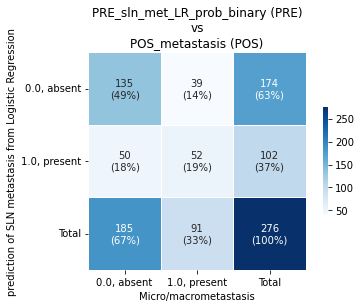

--------------------------------------------------
PRE_sln_met_LR_prob (real, PRE) vs POS_metastasis (categorical, POS)


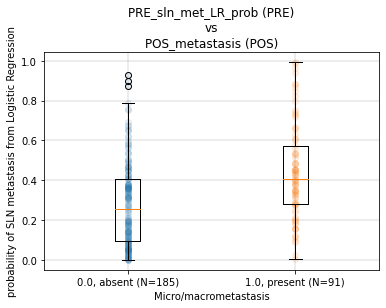

Prediction Probability Threshold: 0.38
Classification Report: 
              precision    recall  f1-score   support

         0.0       0.78      0.73      0.75       185
         1.0       0.51      0.57      0.54        91

    accuracy                           0.68       276
   macro avg       0.64      0.65      0.65       276
weighted avg       0.69      0.68      0.68       276

AUC: 0.702
Threshold for best f1: 0.38
--------------------------------------------------
--------------------------------------------------
PRE_sln_met_EN_prob_binary (categorical, PRE) vs POS_metastasis (categorical, POS)


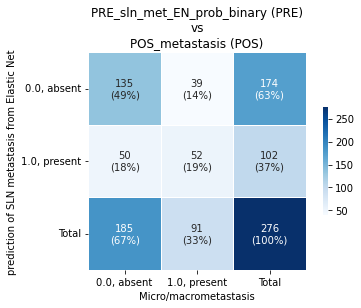

--------------------------------------------------
PRE_sln_met_EN_prob (real, PRE) vs POS_metastasis (categorical, POS)


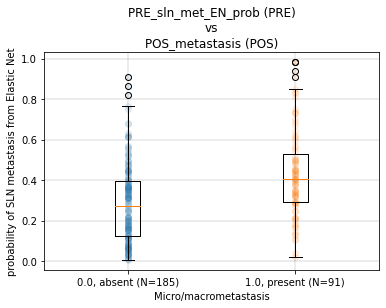

Prediction Probability Threshold: 0.38
Classification Report: 
              precision    recall  f1-score   support

         0.0       0.78      0.73      0.75       185
         1.0       0.51      0.57      0.54        91

    accuracy                           0.68       276
   macro avg       0.64      0.65      0.65       276
weighted avg       0.69      0.68      0.68       276

AUC: 0.7019
Threshold for best f1: 0.54
--------------------------------------------------
--------------------------------------------------
PRE_sln_met_RF_prob_binary (categorical, PRE) vs POS_metastasis (categorical, POS)


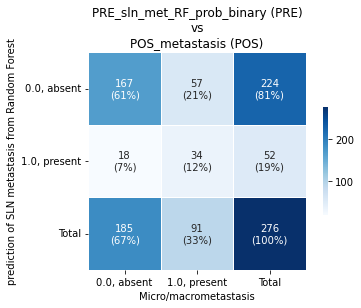

--------------------------------------------------
PRE_sln_met_RF_prob (real, PRE) vs POS_metastasis (categorical, POS)


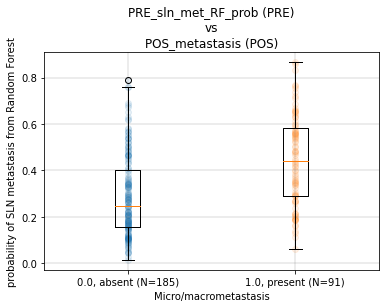

Prediction Probability Threshold: 0.54
Classification Report: 
              precision    recall  f1-score   support

         0.0       0.75      0.90      0.82       185
         1.0       0.65      0.37      0.48        91

    accuracy                           0.73       276
   macro avg       0.70      0.64      0.65       276
weighted avg       0.72      0.73      0.70       276

AUC: 0.7304

The top features for Logistic Regression are:
                                          coeff  absolute  corr w/ targ                                        encoding
PRE_tumor_max_size_composite               0.63      0.63          0.17                                                
PRE_susp_LN_size_composite                 0.61      0.61          0.25                                                
PRE_his_subtype___papillary               -0.47      0.47         -0.09                              0.0, No | 1.0, Yes
PRE_systhe___chemo                        -0.43      0.43          0.01

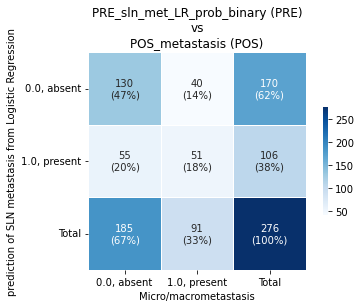

--------------------------------------------------
PRE_sln_met_LR_prob (real, PRE) vs POS_metastasis (categorical, POS)


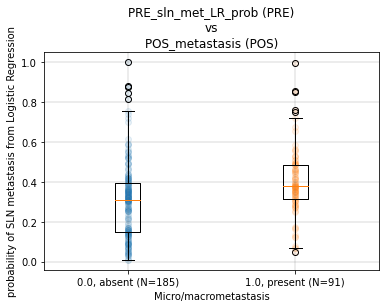

Prediction Probability Threshold: 0.37
Classification Report: 
              precision    recall  f1-score   support

         0.0       0.76      0.70      0.73       185
         1.0       0.48      0.56      0.52        91

    accuracy                           0.66       276
   macro avg       0.62      0.63      0.63       276
weighted avg       0.67      0.66      0.66       276

AUC: 0.6682
Threshold for best f1: 0.42
--------------------------------------------------
--------------------------------------------------
PRE_sln_met_EN_prob_binary (categorical, PRE) vs POS_metastasis (categorical, POS)


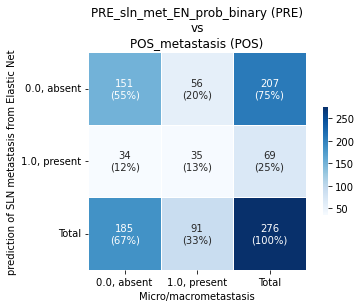

--------------------------------------------------
PRE_sln_met_EN_prob (real, PRE) vs POS_metastasis (categorical, POS)


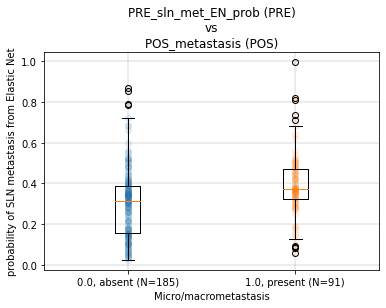

Prediction Probability Threshold: 0.42
Classification Report: 
              precision    recall  f1-score   support

         0.0       0.73      0.82      0.77       185
         1.0       0.51      0.38      0.44        91

    accuracy                           0.67       276
   macro avg       0.62      0.60      0.60       276
weighted avg       0.66      0.67      0.66       276

AUC: 0.6744
Threshold for best f1: 0.4
--------------------------------------------------
--------------------------------------------------
PRE_sln_met_RF_prob_binary (categorical, PRE) vs POS_metastasis (categorical, POS)


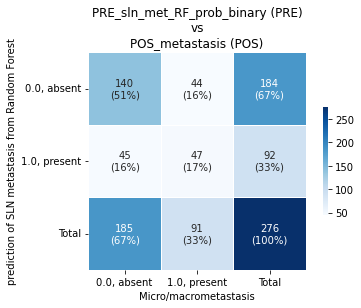

--------------------------------------------------
PRE_sln_met_RF_prob (real, PRE) vs POS_metastasis (categorical, POS)


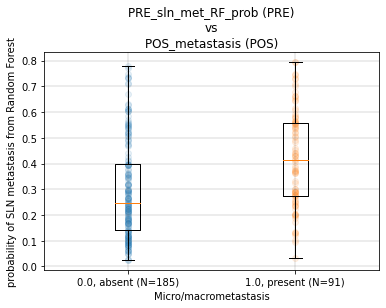

Prediction Probability Threshold: 0.4
Classification Report: 
              precision    recall  f1-score   support

         0.0       0.76      0.76      0.76       185
         1.0       0.51      0.52      0.51        91

    accuracy                           0.68       276
   macro avg       0.64      0.64      0.64       276
weighted avg       0.68      0.68      0.68       276

AUC: 0.6907

The top features for Logistic Regression are:
                                coeff  absolute  corr w/ targ                                        encoding
PRE_tumor_max_size_composite     0.77      0.77          0.17                                                
PRE_his_subtype___idc            0.49      0.49          0.14                              0.0, No | 1.0, Yes
PRE_his_subtype___inv_mucinous  -0.34      0.34         -0.07                              0.0, No | 1.0, Yes
PRE_er_status                   -0.34      0.34         -0.16  1.0, positive | 1.5, equivocal | 2.0, negative
PR

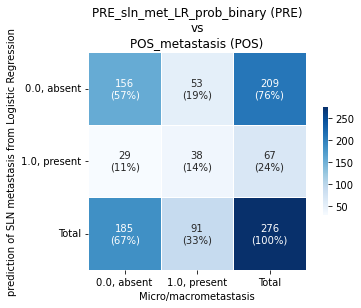

--------------------------------------------------
PRE_sln_met_LR_prob (real, PRE) vs POS_metastasis (categorical, POS)


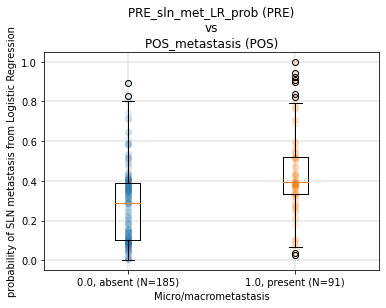

Prediction Probability Threshold: 0.42
Classification Report: 
              precision    recall  f1-score   support

         0.0       0.75      0.84      0.79       185
         1.0       0.57      0.42      0.48        91

    accuracy                           0.70       276
   macro avg       0.66      0.63      0.64       276
weighted avg       0.69      0.70      0.69       276

AUC: 0.7168
Threshold for best f1: 0.41
--------------------------------------------------
--------------------------------------------------
PRE_sln_met_EN_prob_binary (categorical, PRE) vs POS_metastasis (categorical, POS)


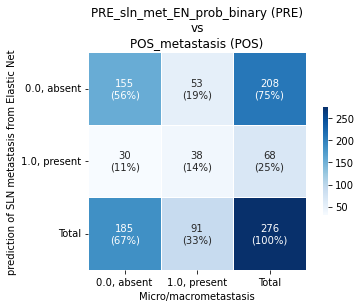

--------------------------------------------------
PRE_sln_met_EN_prob (real, PRE) vs POS_metastasis (categorical, POS)


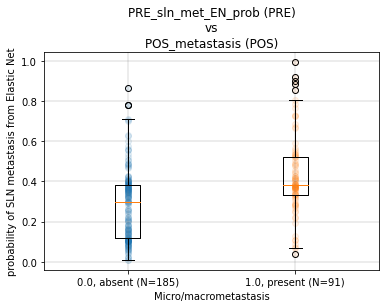

Prediction Probability Threshold: 0.41
Classification Report: 
              precision    recall  f1-score   support

         0.0       0.75      0.84      0.79       185
         1.0       0.56      0.42      0.48        91

    accuracy                           0.70       276
   macro avg       0.65      0.63      0.63       276
weighted avg       0.68      0.70      0.69       276

AUC: 0.7174
Threshold for best f1: 0.41
--------------------------------------------------
--------------------------------------------------
PRE_sln_met_RF_prob_binary (categorical, PRE) vs POS_metastasis (categorical, POS)


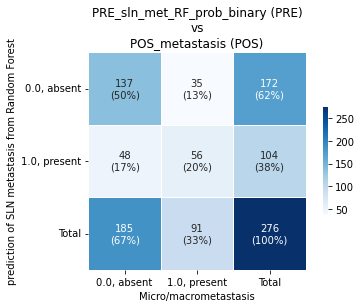

--------------------------------------------------
PRE_sln_met_RF_prob (real, PRE) vs POS_metastasis (categorical, POS)


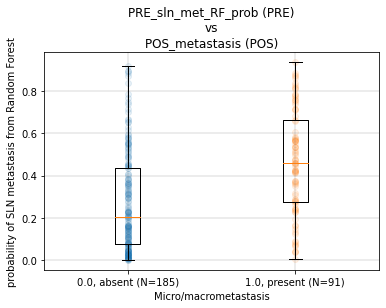

Prediction Probability Threshold: 0.41
Classification Report: 
              precision    recall  f1-score   support

         0.0       0.80      0.74      0.77       185
         1.0       0.54      0.62      0.57        91

    accuracy                           0.70       276
   macro avg       0.67      0.68      0.67       276
weighted avg       0.71      0.70      0.70       276

AUC: 0.7206

The top features for Logistic Regression are:
                                          coeff  absolute  corr w/ targ                                 encoding
PRE_tumor_max_size_composite               0.70      0.70          0.17                                         
PRE_systhe___chemo                        -0.65      0.65          0.01                       0.0, No | 1.0, Yes
PRE_his_subtype___dcis                    -0.47      0.47         -0.19                       0.0, No | 1.0, Yes
PRE_his_subtype___papillary               -0.44      0.44         -0.09                       0.0, 

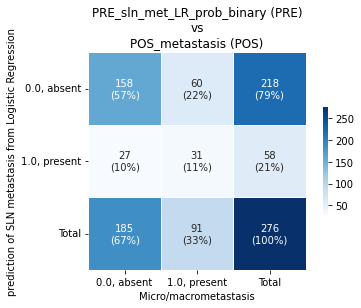

--------------------------------------------------
PRE_sln_met_LR_prob (real, PRE) vs POS_metastasis (categorical, POS)


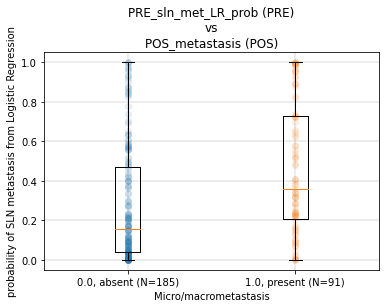

Prediction Probability Threshold: 0.61
Classification Report: 
              precision    recall  f1-score   support

         0.0       0.72      0.85      0.78       185
         1.0       0.53      0.34      0.42        91

    accuracy                           0.68       276
   macro avg       0.63      0.60      0.60       276
weighted avg       0.66      0.68      0.66       276

AUC: 0.6788
Threshold for best f1: 0.44
--------------------------------------------------
--------------------------------------------------
PRE_sln_met_EN_prob_binary (categorical, PRE) vs POS_metastasis (categorical, POS)


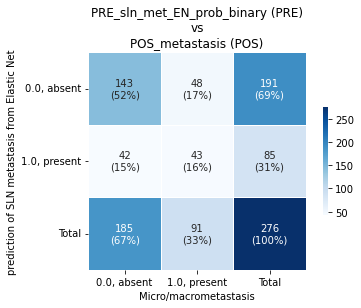

--------------------------------------------------
PRE_sln_met_EN_prob (real, PRE) vs POS_metastasis (categorical, POS)


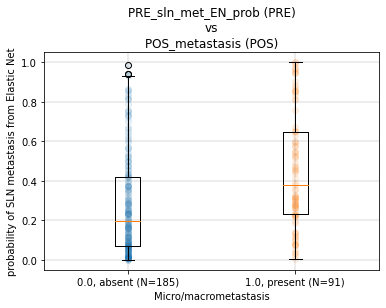

Prediction Probability Threshold: 0.44
Classification Report: 
              precision    recall  f1-score   support

         0.0       0.75      0.77      0.76       185
         1.0       0.51      0.47      0.49        91

    accuracy                           0.67       276
   macro avg       0.63      0.62      0.62       276
weighted avg       0.67      0.67      0.67       276

AUC: 0.6873
Threshold for best f1: 0.49
--------------------------------------------------
--------------------------------------------------
PRE_sln_met_RF_prob_binary (categorical, PRE) vs POS_metastasis (categorical, POS)


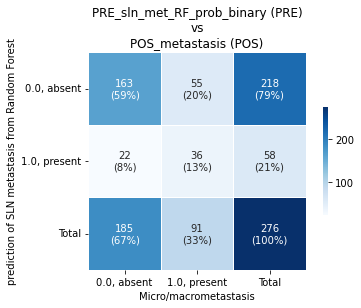

--------------------------------------------------
PRE_sln_met_RF_prob (real, PRE) vs POS_metastasis (categorical, POS)


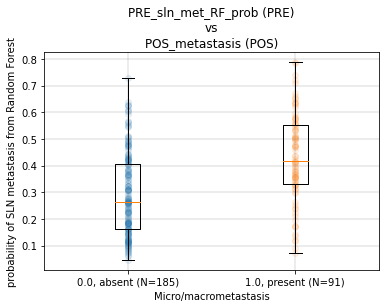

Prediction Probability Threshold: 0.49
Classification Report: 
              precision    recall  f1-score   support

         0.0       0.75      0.88      0.81       185
         1.0       0.62      0.40      0.48        91

    accuracy                           0.72       276
   macro avg       0.68      0.64      0.65       276
weighted avg       0.71      0.72      0.70       276

AUC: 0.7304

The top features for Logistic Regression are:
                                coeff  absolute  corr w/ targ                                           encoding
PRE_systhe___chemo              -1.09      1.09          0.01                                 0.0, No | 1.0, Yes
PRE_men_status                   0.86      0.86          0.08  0.0, pre-menopausal | 1.0, peri-menopausal | 2...
PRE_systhe___radiation          -0.72      0.72         -0.06                                 0.0, No | 1.0, Yes
PRE_susp_LN_size_composite       0.70      0.70          0.25                                      

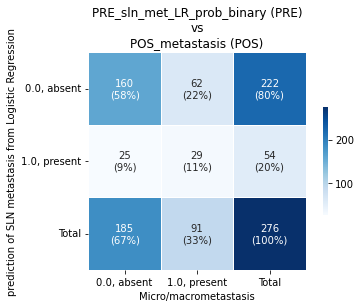

--------------------------------------------------
PRE_sln_met_LR_prob (real, PRE) vs POS_metastasis (categorical, POS)


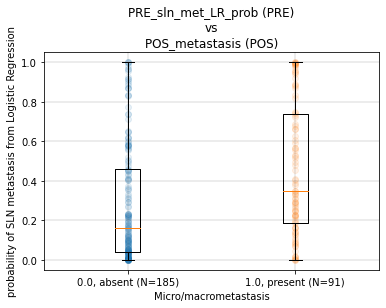

Prediction Probability Threshold: 0.65
Classification Report: 
              precision    recall  f1-score   support

         0.0       0.72      0.86      0.79       185
         1.0       0.54      0.32      0.40        91

    accuracy                           0.68       276
   macro avg       0.63      0.59      0.59       276
weighted avg       0.66      0.68      0.66       276

AUC: 0.6711
Threshold for best f1: 0.53
--------------------------------------------------
--------------------------------------------------
PRE_sln_met_EN_prob_binary (categorical, PRE) vs POS_metastasis (categorical, POS)


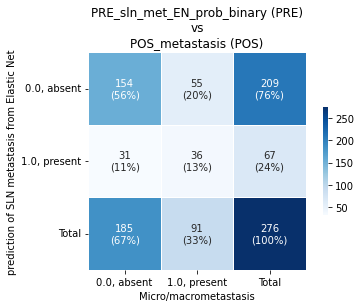

--------------------------------------------------
PRE_sln_met_EN_prob (real, PRE) vs POS_metastasis (categorical, POS)


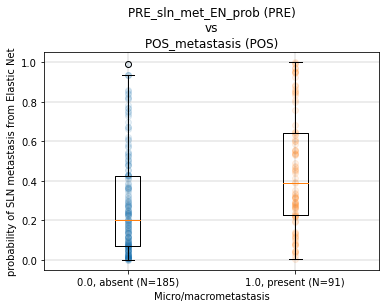

Prediction Probability Threshold: 0.53
Classification Report: 
              precision    recall  f1-score   support

         0.0       0.74      0.83      0.78       185
         1.0       0.54      0.40      0.46        91

    accuracy                           0.69       276
   macro avg       0.64      0.61      0.62       276
weighted avg       0.67      0.69      0.67       276

AUC: 0.6854
Threshold for best f1: 0.46
--------------------------------------------------
--------------------------------------------------
PRE_sln_met_RF_prob_binary (categorical, PRE) vs POS_metastasis (categorical, POS)


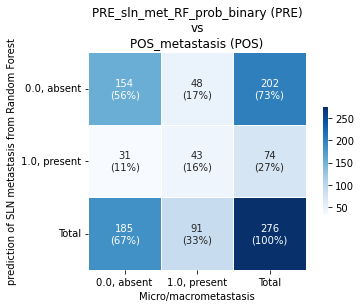

--------------------------------------------------
PRE_sln_met_RF_prob (real, PRE) vs POS_metastasis (categorical, POS)


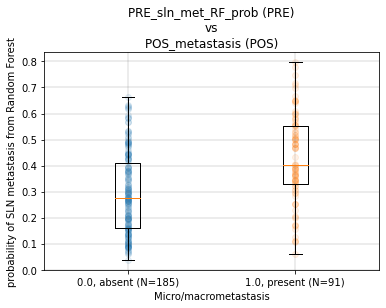

Prediction Probability Threshold: 0.46
Classification Report: 
              precision    recall  f1-score   support

         0.0       0.76      0.83      0.80       185
         1.0       0.58      0.47      0.52        91

    accuracy                           0.71       276
   macro avg       0.67      0.65      0.66       276
weighted avg       0.70      0.71      0.71       276

AUC: 0.721

The top features for Logistic Regression are:
                                coeff  absolute  corr w/ targ                                           encoding
PRE_systhe___chemo              -1.09      1.09          0.01                                 0.0, No | 1.0, Yes
PRE_men_status                   0.85      0.85          0.08  0.0, pre-menopausal | 1.0, peri-menopausal | 2...
PRE_systhe___radiation          -0.72      0.72         -0.06                                 0.0, No | 1.0, Yes
PRE_int_mammary_lymphade_pet     0.70      0.70          0.11                                       

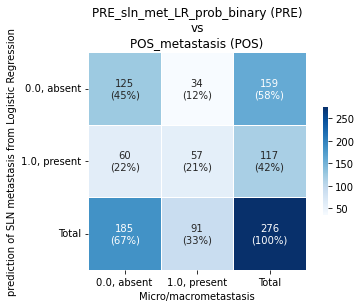

--------------------------------------------------
PRE_sln_met_LR_prob (real, PRE) vs POS_metastasis (categorical, POS)


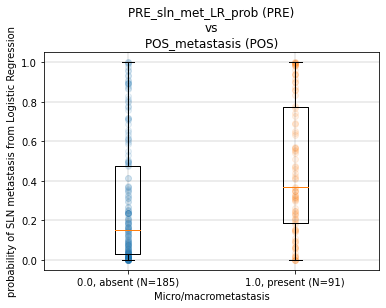

Prediction Probability Threshold: 0.3
Classification Report: 
              precision    recall  f1-score   support

         0.0       0.79      0.68      0.73       185
         1.0       0.49      0.63      0.55        91

    accuracy                           0.66       276
   macro avg       0.64      0.65      0.64       276
weighted avg       0.69      0.66      0.67       276

AUC: 0.6806
Threshold for best f1: 0.46
--------------------------------------------------
--------------------------------------------------
PRE_sln_met_EN_prob_binary (categorical, PRE) vs POS_metastasis (categorical, POS)


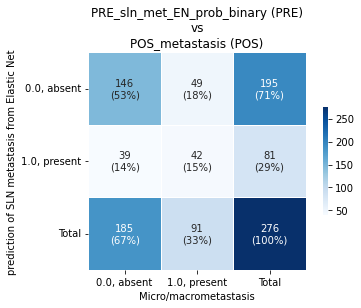

--------------------------------------------------
PRE_sln_met_EN_prob (real, PRE) vs POS_metastasis (categorical, POS)


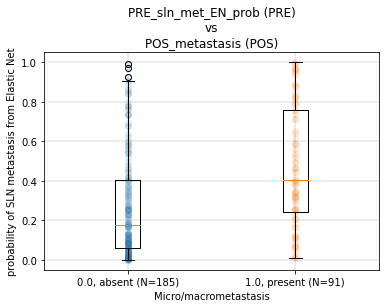

Prediction Probability Threshold: 0.46
Classification Report: 
              precision    recall  f1-score   support

         0.0       0.75      0.79      0.77       185
         1.0       0.52      0.46      0.49        91

    accuracy                           0.68       276
   macro avg       0.63      0.63      0.63       276
weighted avg       0.67      0.68      0.68       276

AUC: 0.7038
Threshold for best f1: 0.42
--------------------------------------------------
--------------------------------------------------
PRE_sln_met_RF_prob_binary (categorical, PRE) vs POS_metastasis (categorical, POS)


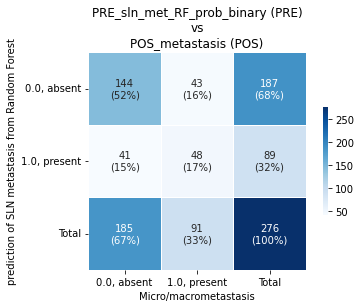

--------------------------------------------------
PRE_sln_met_RF_prob (real, PRE) vs POS_metastasis (categorical, POS)


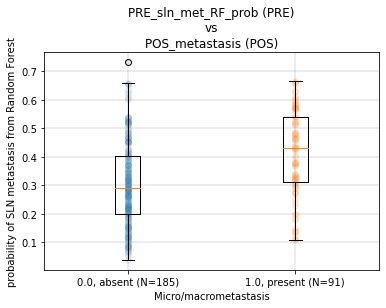

Prediction Probability Threshold: 0.42
Classification Report: 
              precision    recall  f1-score   support

         0.0       0.77      0.78      0.77       185
         1.0       0.54      0.53      0.53        91

    accuracy                           0.70       276
   macro avg       0.65      0.65      0.65       276
weighted avg       0.69      0.70      0.69       276

AUC: 0.6985

The top features for Logistic Regression are:
                                coeff  absolute  corr w/ targ                                           encoding
PRE_systhe___chemo              -1.15      1.15          0.01                                 0.0, No | 1.0, Yes
PRE_men_status                   0.86      0.86          0.08  0.0, pre-menopausal | 1.0, peri-menopausal | 2...
PRE_int_mammary_lymphade_pet     0.75      0.75          0.11                                                   
PRE_gensus___brca1              -0.73      0.73         -0.13                                 0.0, 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ValueError: multi_class must be in ('ovo', 'ovr')

In [30]:
# Import SKLearn ML modules
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegressionCV
from collections import defaultdict
# Build our own model to predict the probability of metastasis using PRE data
# Filter dataframe columns to keep only the columns that start with "PRE_" or is target_col

feature_score_dict = defaultdict(dict)
for target_col, col_name in zip(["POS_metastasis", "POS_mar_status", "POS_did_the_patient_receive_pm", "POS_tumor_focality", "POS_tu_grade"], ["sln_met", "mar_status", "did_the_patient_receive_pm", "tumor_focality", "tu_grade"]):
    print("\n"*5)
    print("="*50,"Target column:", target_col,"="*50)
    filtered_cols = [col for col in df.columns if (col.startswith("PRE_") or col == target_col) and not "nomogram" in col]
    df_PRE = df[filtered_cols].copy()
    assert target_col in df_PRE.columns, f"{target_col} not in {df_PRE.columns}"

    # Drop rows with NaN in POS_metastasis
    df_PRE = df_PRE[df_PRE[target_col].notnull()]
    # Drop columns with all NaN
    df_PRE = df_PRE.dropna(axis=1, how="all")

    # Get a list of columns that have ≤ 20% missing values in df_PRE
    missing_cols_20 = [col for col in df_PRE.columns if df_PRE[col].isna().sum() / len(df_PRE) <= 0.2]
    # Get a list of columns that have ≤ 50% missing values in df_PRE
    missing_cols_50 = [col for col in df_PRE.columns if df_PRE[col].isna().sum() / len(df_PRE) <= 0.5]
    all_cols = [col for col in df_PRE.columns]

    # for cols_subset, col_subset_name in zip([top_12_EN_union_nomogram, top_12_EN_cols, top_12_LR_cols, top_12_RF_cols, missing_cols_20, missing_cols_50, all_cols], ["12EN + Nomogram", "12EN", "12LR", "12RF", "20%", "50%", "all"]):
    for cols_subset, col_subset_name in zip([top_12_EN_union_nomogram, nomogram_cols, top_12_EN_cols, missing_cols_20, missing_cols_50, all_cols], ["12EN + Nomogram", "Nomogram", "12EN", "20%", "50%", "all"]):
        print("\n" * 3 + "-"*20 + f"{col_subset_name} columns ({len(cols_subset)} cols)" + "-"*20)
        if target_col not in cols_subset:
            cols_subset.append(target_col)
        cols_subset = [col for col in cols_subset if col in df_PRE.columns]
        # df_temp = df_PRE.loc[df_PRE["PRE_susp_LN_prsnt_composite"].isin([0, 3, np.nan])]
        df_temp = df_PRE.copy()
        df_temp = df_temp[cols_subset]
        df_temp = df_temp.reset_index(drop=True)
        df_temp = impute_missing_value(df_temp, target_col, max_iter=100)
        X = df_temp.drop(target_col, axis=1)
        y = df_temp[target_col]
        # Standardize the data
        X = (X - X.mean()) / X.std()
        # Drop columns with all NaN
        X = X.dropna(axis=1, how="all")

        assert X.isnull().sum().sum() == 0

        print(f"The shape of X and y are: {X.shape}, {y.shape}")
        assert len(df_temp) == len(X)
        # Use stratified 10-fold cross-validation
        kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
        # Create a list of lists of train and test indices
        kf_indices = list(kf.split(X, y))
        for train_index, test_index in kf_indices:
            X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y.iloc[train_index], y.iloc[test_index]
            logreg = LogisticRegression(max_iter=2000, random_state=0)
            en_classifier = LogisticRegression(C=0.5, penalty='elasticnet', l1_ratio=0.5, solver='saga', max_iter=2000, random_state=0)
            rf = RandomForestClassifier(n_estimators=2000, random_state=5)
            # Standardize (center and scale) the training data for the regression classifiers
            X_train_standardized = (X_train - X_train.mean()) / X_train.std()
            logreg.fit(X_train_standardized, y_train)
            en_classifier.fit(X_train_standardized, y_train)
            rf.fit(X_train, y_train)
            # Predict probabilities on test set
            X_test_standardized = (X_test - X_train.mean()) / X_train.std()
            y_pred_logreg = logreg.predict_proba(X_test_standardized)[:, 1]
            y_pred_elastic = en_classifier.predict_proba(X_test_standardized)[:, 1]
            y_pred_rf = rf.predict_proba(X_test)[:, 1]
            # Add the predictions to df_temp
            df_temp.loc[test_index, "PRE_sln_met_LR_prob"] = y_pred_logreg
            df_temp.loc[test_index, "PRE_sln_met_EN_prob"] = y_pred_elastic
            df_temp.loc[test_index, "PRE_sln_met_RF_prob"] = y_pred_rf
        
        evaluate_predictions(df_temp, "PRE_sln_met_LR_prob", target_col, find_threshold(df_temp, "PRE_sln_met_LR_prob", target_col, threshold_metric), "Logistic Regression", show_results=True)
        evaluate_predictions(df_temp, "PRE_sln_met_EN_prob", target_col, find_threshold(df_temp, "PRE_sln_met_EN_prob", target_col, threshold_metric), "Elastic Net", show_results=True)
        evaluate_predictions(df_temp, "PRE_sln_met_RF_prob", target_col, find_threshold(df_temp, "PRE_sln_met_RF_prob", target_col, threshold_metric), "Random Forest", show_results=True)
        X_and_y = pd.concat([X, y], axis=1)
        # Calculate the correlation between each feature to the target
        correlations = X_and_y.corr()[target_col]

        # Print the feature scores along with their names
        feature_scores_LR = pd.DataFrame({"coeff": logreg.coef_[0], "absolute": np.abs(logreg.coef_[0]), "corr w/ targ": correlations.drop(target_col), "encoding": X.columns.map(lambda x: VarReader.read_var_attrib(x, VarReader.has_missing(df_temp, x))["options_str"])})
        feature_scores_EN = pd.DataFrame({"coeff": en_classifier.coef_[0], "absolute": np.abs(en_classifier.coef_[0]), "corr w/ targ": correlations.drop(target_col), "encoding": X.columns.map(lambda x: VarReader.read_var_attrib(x, VarReader.has_missing(df_temp, x))["options_str"])})
        feature_scores_RF = pd.DataFrame({"importance": rf.feature_importances_, "corr w/ targ": correlations.drop(target_col), "encoding": X.columns.map(lambda x: VarReader.read_var_attrib(x, VarReader.has_missing(df_temp, x))["options_str"])})
        # Sort by absolute value of the feature scores
        feature_scores_LR = feature_scores_LR.sort_values(by="absolute", ascending=False)
        feature_scores_EN = feature_scores_EN.sort_values(by="absolute", ascending=False)
        feature_scores_RF = feature_scores_RF.sort_values(by="importance", ascending=False)
        # Round both dataframes to 2 decimal places
        feature_scores_LR = feature_scores_LR.round(2)
        feature_scores_EN = feature_scores_EN.round(2)
        feature_scores_RF = feature_scores_RF.round(2)
        feature_score_dict[col_name][col_subset_name] = {"LR": feature_scores_LR, "EN": feature_scores_EN, "RF": feature_scores_RF}
        # Print the top 20 features
        print(f"\nThe top features for Logistic Regression are:\n{feature_scores_LR.head(20)}")
        print(f"\nThe top features for Elastic Net are:\n{feature_scores_EN.head(20)}")
        print(f"\nThe top features for Random Forest are:\n{feature_scores_RF.head(20)}")

In [ ]:
top_12_EN_cols

['PRE_years_btw_dximg_surg',
 'PRE_systhe___chemo',
 'PRE_susp_LN_size_composite',
 'PRE_dximg___ultrasound',
 'PRE_gensus___brca1',
 'PRE_his_subtype___idc',
 'PRE_dximg_date',
 'PRE_surg_indicat_prim___recurrent_cancer',
 'PRE_axillary_lymph_node_max_si',
 'PRE_his_subtype___dcis',
 'PRE_his_subtype___papillary',
 'PRE_metastatic_carcinoma_on_ax',
 'PRE_tumor_max_size_composite',
 'POS_metastasis']

In [ ]:
temp_feature_df = feature_score_dict["sln_met"]["all"]["EN"]
temp_feature_df

,coeff,absolute,corr w/ targ,encoding,idx
PRE_systhe___chemo,-0.75,0.75,0.01,"0.0, No | 1.0, Yes",0
PRE_men_status,0.65,0.65,0.08,"0.0, pre-menopausal | 1.0, peri-menopausal | 2...",1
PRE_systhe___radiation,-0.44,0.44,-0.06,"0.0, No | 1.0, Yes",2
PRE_int_mammary_lymphade_pet,0.41,0.41,0.11,,3
PRE_axillary_lymph_node_core_b,0.41,0.41,0.29,"0.0, No | 1.0, Yes",4
PRE_susp_LN_size_composite,0.40,0.40,0.25,,5
PRE_systhe___no_systhe,-0.40,0.40,-0.07,"0.0, No | 1.0, Yes",6
PRE_bi_rads_score,0.38,0.38,0.17,,7
PRE_img_size,0.38,0.38,0.19,,8
PRE_foci,0.32,0.32,0.14,,9
